In [1]:
import concurrent.futures

import numpy as np
from scipy.signal import welch
from matplotlib import pyplot as plt

from src.randflow import GeneratorFactory, Point

In [55]:
class Terrain(object):
    __omega = 72.9E-6

    def __init__(self, u_ref, H_ref, z0, alpha, I10, latitude) -> None:
        self.u_ref = u_ref
        self.H_ref = H_ref
        self.z0 = z0
        self.alpha = alpha
        self.I10 = I10
        self.latitude = latitude

    def vel(self, z):
        return self.u_ref * np.power((z / self.H_ref), self.alpha)

    def __h(self):
        u_fric = self.vel(10)*0.94 / (2.5 * np.log(10 / self.z0))
        f = 2 * Terrain.__omega * np.sin(np.deg2rad(self.latitude))
        return u_fric / (6 * f)

    def turblence(self, z):
        Iu = self.I10 * np.power((z / 10), -self.alpha)
        Lu = 300 * np.power((z / 300), 0.46 + 0.074 * np.log(self.z0))
        sigma_v_u = 1 - 0.22 * np.power(np.cos(np.pi / 2 * z / self.__h()), 4)
        sigma_w_u = 1 - 0.45 * np.power(np.cos(np.pi / 2 * z / self.__h()), 4)
        Iv = Iu * sigma_v_u
        Iw = Iu * sigma_w_u
        Lv = 0.5 * sigma_v_u**3 * Lu
        Lw = 0.5 * sigma_w_u**3 * Lu
        return (Iu, Iv, Iw, Lu, Lv, Lw)
        
class Scale(object):
    def __init__(self,length_scale,velocity_scale) -> None:
        self.len=length_scale
        self.vel=velocity_scale
        self.freq=velocity_scale/length_scale
        self.time = length_scale / velocity_scale
        self.forc=length_scale**2*velocity_scale**2
        self.torq=length_scale**3*velocity_scale**2
        self.spec=length_scale*velocity_scale

In [56]:
terr = Terrain(20, 182.88, 0.7, 0.22, 0.23, 23.167)
scale = Scale(1 / 300, 3.5/20)
# prototype
x = np.linspace(0, 2, 21) / scale.len
y = np.linspace(-1, 1, 21) / scale.len
y = np.delete(y, 10)
z = np.linspace(0.1, 2, 20) / scale.len
z = np.delete(z, 9)
coord = [(x[i], 0, 300) for i in range(21)]
coord.extend([(0, y[i], 300) for i in range(20)])
coord.extend([(0, 0, z[i]) for i in range(19)])
plist = [Point('p' + str(i), coord[i], terr.vel(coord[i][2]), terr.turblence(coord[i][2])) for i in range(60)]
fs = 200 / scale.freq
time = np.arange(0, 10 + 1 / 200, 1 / 200) / scale.time
gen = GeneratorFactory.create_generator('NSRFG', {'N': 1000, 'fmax': 100 / scale.freq, 'target_spectrum': 'vonKarman'})
fluct = dict()
spec = dict()
for p in plist:
    fluct[p], spec[p] = gen.create_fluct(time, p)

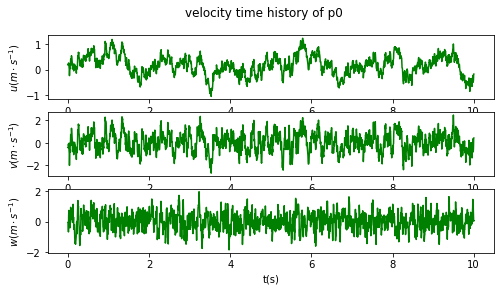

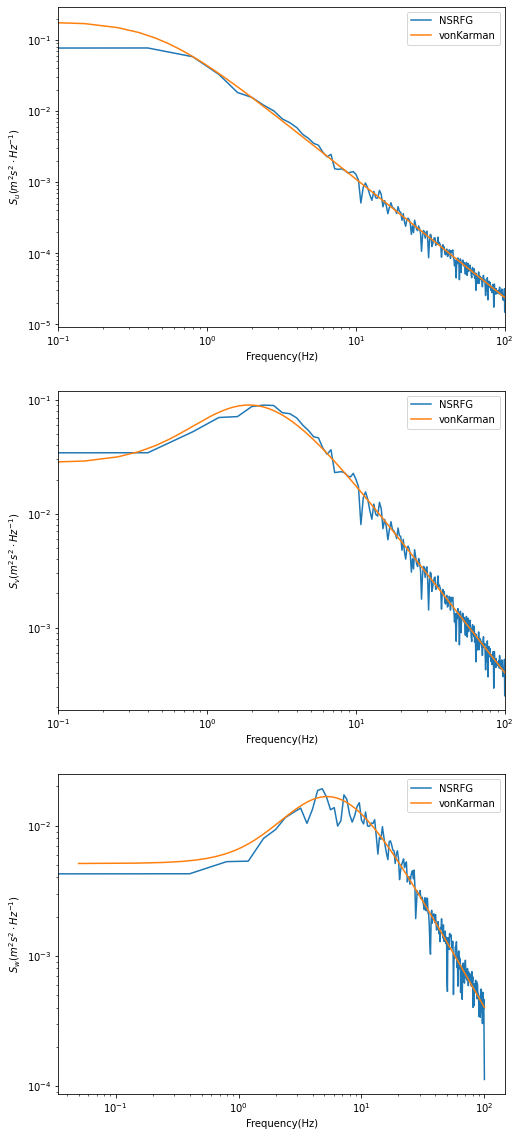

In [57]:
plot_point = plist[0]
[u, v, w] = [fluct[plot_point][i]*scale.vel for i in range(3)]
[Su, Sv, Sw] = [spec[plot_point][i] * scale.spec for i in range(3)]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 4))
ax1.plot(time * scale.time, u, 'g-')
ax1.set_xlabel('t(s)')
ax1.set_ylabel(r'$u(m\cdot s^{-1})$')
ax2.plot(time * scale.time, v, 'g-')
ax2.set_xlabel('t(s)')
ax2.set_ylabel(r'$v(m\cdot s^{-1})$')
ax3.plot(time * scale.time, w, 'g-')
ax3.set_xlabel('t(s)')
ax3.set_ylabel(r'$w(m\cdot s^{-1})$')
fig.suptitle('velocity time history of ' + plot_point.name)
length = len(u)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 20))
f, pxx = welch(u, fs * scale.freq, window='hamming', nperseg=length // 4)
ax1.loglog(f, pxx, label='NSRFG')
ax1.loglog(gen.fn * scale.freq, Su, label=gen.target_spectrum)
ax1.set_xlabel('Frequency(Hz)')
ax1.set_ylabel(r'$S_u(m^2s^2\cdot Hz^{-1})$')
ax1.set_xlim(0.1,100)
ax1.legend()
f, pxx = welch(v, fs * scale.freq, window='hamming', nperseg=length // 4)
ax2.loglog(f, pxx, label='NSRFG')
ax2.loglog(gen.fn * scale.freq, Sv, label=gen.target_spectrum)
ax2.set_xlabel('Frequency(Hz)')
ax2.set_ylabel(r'$S_v(m^2s^2\cdot Hz^{-1})$')
ax2.set_xlim(0.1,100)
ax2.legend()
f, pxx = welch(w, fs * scale.freq, window='hamming', nperseg=length // 4)
ax3.loglog(f, pxx, label='NSRFG')
ax3.loglog(gen.fn * scale.freq, Sw, label=gen.target_spectrum)
ax3.set_xlabel('Frequency(Hz)')
ax3.set_ylabel(r'$S_w(m^2s^2\cdot Hz^{-1})$')
# ax3.set_xlim(0.1,100)
ax3.legend()
# plt.show()

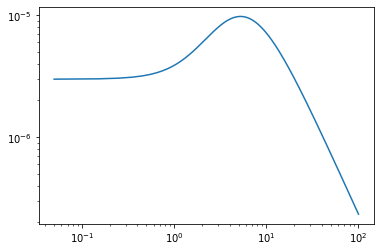

In [58]:
fig, ax1=plt.subplots()

ax1.loglog(gen.fn * scale.freq, Sw * scale.spec, label=gen.target_spectrum)

In [59]:
plist[0].z

300